# From Ilastik Masks to Labels

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
# ]
# ///

## <mark style="color: black; background-color: rgb(127,196,125); padding: 3px; border-radius: 5px;">Description</mark>

This notebook demonstrates how to convert the **semantic segmentation** generated by **Ilastik** (Simple Segmentation) into **instance segmentation**.

<div align="center"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/ilastik/sem_to_inst.png" alt="Ilastik Logo" width="600"></div>

<br>

We first explore the type of data that we generated with Ilastik in the previous section ([Ilastik for Pixel Classification](pixel_classification_with_ilastik.md)) and we then use them to generate labels, which can be used for instance segmentation (as we did in [classical segmentation methods](../classic/classic.md)).

***TODO: UPDATE LINK TO CLASSIC SEGMENTATION METHODS SECTION***

### <mark style="color: black; background-color: rgb(190,223,185); padding: 3px; border-radius: 5px;">Import libraries</mark>

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from scipy import ndimage
from skimage import color, feature, measure, segmentation

### <mark style="color: black; background-color: rgb(190,223,185); padding: 3px; border-radius: 5px;">Explore the Data</mark>

Let's first load one of the *_Simple Segmentation.tif* files and explore the data that we generated with Ilastik. We want to know the type of data that we have before we can convert it to labels (instance segmentation).

Choose one of the *_Simple Segmentation.tif* files path and store it in a variable called `seg_path`.

In [ ]:
# set the path to one of the *_Simple Segmentation.tif files
seg_path = "../../../_static/images/ilastik/ilastik_Simple Segmentation.tif"

We can use the `tifffile` library to read the tif file.

In [ ]:
# Load a mask
seg = tifffile.imread(seg_path)

What is the data type?

In [ ]:
print(seg.dtype)
print(type(seg))

With can now use the `ndv` library to display the data and **explore the pixel values**.

What are the values? Is this a [0 1] binary mask?

In [ ]:
# show the mask image
ndv.imshow(seg)

By exploring the results we can notice that all **the pixels within the nuclei regions have a value of 1**, while the **background has a value of 2**.

This is because Ilastik assigns integer to classes starting from 1, based on the number and the order of the classes defined during the training phase. For instance, in our case, we defined two classes: the first class corresponds to the nuclei, and the second class corresponds to the background. As a result, the nuclei are labeled with the value 1 and the background with the value 2.

Remember that in order to generate labels form the data, **we need binary masks** with pixel values of **0 for the background** and **1 for our object of interest**, the nuclei.

How can we convert them to binary?

### <mark style="color: black; background-color: rgb(190,223,185); padding: 3px; border-radius: 5px;">Data to Binary Masks</p></mark>

In [65]:
# Convert to a binary mask
# The nuclei pixels have all value 1, the seg image is a numpy array.
# We can create a new bunary mask by keeping only the pixels with value 1.
binary_mask = seg == 1

If we explore the binary masks with ndv, we can now see that the background has a value of 0 and the nuclei have a value of 1.

In [ ]:
ndv.imshow(binary_mask)

### <mark style="color: black; background-color: rgb(190,223,185); padding: 3px; border-radius: 5px;">Binary Masks to Labels</p></mark>

Now that we have the binary mask, we can convert it to labels (instance segmentation) as we did in the [classic segmentastion methods](../classic/classic.md) section.

***TODO: UPDATE LINK TO CLASSIC SEGMENTATION METHODS SECTION***

In [98]:
# compute the distance transform
distance = ndimage.distance_transform_edt(binary_mask)
# find local maxima in the distance transform
local_maxima_coords = feature.peak_local_max(
    distance, footprint=np.ones((25, 25)), min_distance=10
)
# create a binary image from the local maxima coordinates
local_maxima = np.zeros_like(binary_mask, dtype=bool)
local_maxima[tuple(local_maxima_coords.T)] = True
# use the local maxima to create seeds for the watershed algorithm
seeds = measure.label(local_maxima)
# apply the watershed algorithm to segment the image and get labels
labels = segmentation.watershed(-distance, seeds, mask=binary_mask)

We can now plot the labels and check the results using scikit-image's `label2rgb` function.

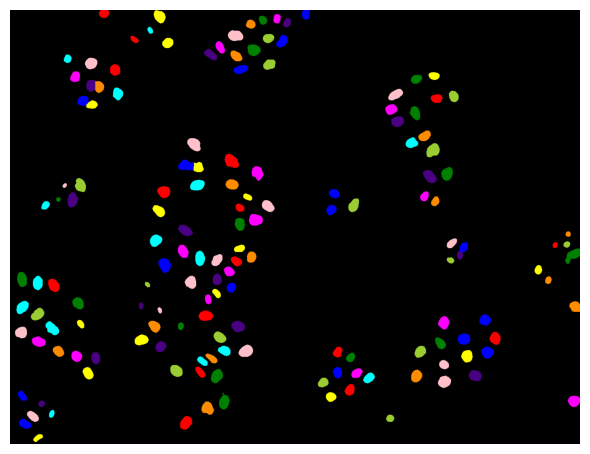

In [99]:
img = color.label2rgb(labels, bg_label=0)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
ax.axis("off")
plt.tight_layout()
plt.show()

We can also save the labels as a tif file using the `tifffile` library.

<p class="alert alert-info">
    <strong>NOTE:</strong> The <i>dtype</i> of the labels image is important because will determine the maximum number of labels that can be stored in the image. Infact, in a label image, each object is assigned a unique integer label, and the <i>dtype</i> determines the range of integers that can be used for labeling (e.g. <i>uint8</i> -> max 255 objects).
    <br>
    By default, the labels generated by the `skimage.measure.label` function are of type <i>uint32</i>, which is also one of the types that Ilastik requires when we will explore the <strong>Object Classification</strong> workflow. Therefore, we will use <i>uint32</i> as the <i>dtype</i> when saving the labels image.
</p>

In [ ]:
tifffile.imwrite("ilastik_Simple Segmentation_labels.tif", labels.astype("uint32"))

### <mark style="color: black; background-color: rgb(190,223,185); padding: 3px; border-radius: 5px;">Batch Processing</p></mark>

Since we now understand how to deal with the `Simple Segmentation` data from **Ilastik**, in order to obtain instance segmentation from all the *_Simple Segmentation.tif* files we generated, we can modify the batch script we used in the [classic segmentation methods](../classic/classic.md) section by simply adding the line of code where we select only the pixels with a value of 1 to only consider the nuclei.

***TODO: UPDATE LINK TO CLASSIC SEGMENTATION METHODS SECTION***

### <mark style="color: black; background-color: rgb(252,185,118); padding: 3px; border-radius: 5px;">✍️ Exercise: Batch Masks to Labels</mark>

Write a script that will convert all the *_Simple Segmentation.tif* images generated by Ilastik into labels images (instance segmentation) and save them as tif files.

In [ ]:
# make a function to create labels from a _Simple Segmentation.tif file
def ilastik_seg_to_labels(seg_image: np.ndarray, object_index: int) -> np.ndarray:
    """Convert an ilastik simpole segmentation image to labeled image.

    Parameters
    ----------
    seg_image : np.ndarray
        The input segmentation image generated by ilastik.
    object_index : int
        The index of the object to segment (e.g. 1 if your objects have value 1).
    """
    # convert to a binary mask
    binary_mask = seg_image == object_index
    # compute the distance transform
    distance = ndimage.distance_transform_edt(binary_mask)
    # find local maxima in the distance transform
    local_maxima_coords = feature.peak_local_max(
        distance, footprint=np.ones((25, 25)), min_distance=10
    )
    # create a binary image from the local maxima coordinates
    local_maxima = np.zeros_like(binary_mask, dtype=bool)
    local_maxima[tuple(local_maxima_coords.T)] = True
    # use the local maxima to create seeds for the watershed algorithm
    seeds = measure.label(local_maxima)
    # apply the watershed algorithm to segment the image and get labels
    return segmentation.watershed(-distance, seeds, mask=binary_mask)


# set the input directory to the path of the _Simple Segmentation.tif files
input_dir = Path("my_input_directory")
# set the output directory to save the labels
output_dir = Path("my_output_directory")

for seg_file in input_dir.glob("*_Simple Segmentation.tif"):
    seg_image = tifffile.imread(seg_file)
    labels = ilastik_seg_to_labels(seg_image, object_index=1)
    output_file = output_dir / f"{seg_file.stem}_labels.tif"
    tifffile.imwrite(output_file, labels.astype("uint32"))